Une analyse du nombre d’établissements par secteur d’activité et par taille en 2014

https://www.insee.fr/fr/statistiques/1893274

https://www.kaggle.com/etiennelq/french-employment-by-town

In [1]:
#chargement des bibliothèques logicielles
import pandas as pd
import numpy as np
import numbers

import re

import json
import geojson

import os

import folium

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

#chargement des données
df_tranche = pd.read_csv('data/base_etablissement_par_tranche_effectif.csv')
df_salaire = pd.read_csv('data/net_salary_per_town_categories.csv')
df_population = pd.read_csv('data/population.csv')
df_geo = pd.read_csv('data/name_geographic_information.csv')

with open('./data/communes.geojson') as f:
    json_communes = json.load(f)

with open('./data/departements.geojson') as f:
    json_departements = json.load(f)

#Display all outputs from cells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

c:\users\sam\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:2705: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
%qtconsole

Data Preparation

base_etablissement_par_tranche_effectif.csv

In [3]:
#Check tranche data
df_tranche.dtypes

# df_tranche.DEP.astype('int')
# df_tranche.CODGEO.astype('int')

#How many geo codes are not numeric?
counter = 0
geo_index = list()

for i in df_tranche.CODGEO:
    try: test = int(i)
    except:
        counter += 1
        geo_index.append(i)
        

print('non-numeric geo codes:' + str(counter))

#And Departements?
counter = 0
dep_index = list()

for i in df_tranche.DEP:
    try: test = int(i)
    except: 
        counter += 1
        dep_index.append(i)
        
print('non-numeric departements:' + str(counter))

#Check the total column adds up
np.sum(df_tranche['E14TST'] == df_tranche.iloc[:,5:14].\
       apply(np.sum, axis = 1)) == df_tranche.shape[0]

CODGEO      object
LIBGEO      object
REG          int64
DEP         object
E14TST       int64
E14TS0ND     int64
E14TS1       int64
E14TS6       int64
E14TS10      int64
E14TS20      int64
E14TS50      int64
E14TS100     int64
E14TS200     int64
E14TS500     int64
dtype: object

non-numeric geo codes:360
non-numeric departements:360


True

name_geographic_information.csv

In [4]:
#Check geo data 
df_geo.dtypes

#Check for missing values
df_geo.head(5)

test = np.repeat(False, df_geo.shape[0])

#Across all columns
for col in df_geo.columns:
    #Find the rows with None records
    col_test = df_geo[col] == None
    test = test | col_test
    
    #Find rows with NaN records
    if isinstance(df_geo[col][0], numbers.Number):
        col_test2 = np.isnan(df_geo[col])
        test = test | col_test2

#Looks like the problem is missing long / lat / eloignement
df_geo[test]

#Convert to correct data types

#Matseille has three post codes delimited by whitespace
df_geo[df_geo.codes_postaux == '13001 13004 13012 ']

#Testing for castability
def num_castable(x):
    try:
        return(isinstance(float(x), float))
    except:
        return(False)

#So this is actually an array column delimited by whitespace
df_geo[np.logical_not(df_geo.codes_postaux.apply(num_castable))]

#Split and convert to float
#length condition deals with trailing white space
df_geo.codes_postaux = df_geo.codes_postaux.apply(lambda x: ([float(i) for i in x.split(" ") if len(i) > 0]))

#Do we need this?
df_geo['code_postale_max'] = df_geo.codes_postaux.apply(max)

#This has strings in it
df_geo[df_geo.numéro_département == '2A']

#Finally something that works
df_geo.code_insee.astype('int')

#Longitude
# ValueError: could not convert string to float: '3,28'
# df_geo.longitude.astype("float")

#They've mixed up French and English decimal notation, so it has loaded longitude as str
#Replace commas and convert to numeric if necessary
def decimal_translate(x):
    try:
        return(float(x))
    #Cases where it can't cast
    except:
        #French decimal
        x = re.sub(",", ".", x)
        #For where they are using '-' as a null value
        if x == '-':
            x = float("NaN")
        return(float(x))
        
df_geo.longitude = df_geo.longitude.apply(decimal_translate)

#There are some with latitude but not longitude
df_geo[np.isnan(df_geo.latitude) & np.logical_not((np.isnan(df_geo.longitude)))]


EU_circo                   object
code_région                 int64
nom_région                 object
chef.lieu_région           object
numéro_département         object
nom_département            object
préfecture                 object
numéro_circonscription      int64
nom_commune                object
codes_postaux              object
code_insee                  int64
latitude                  float64
longitude                  object
éloignement               float64
dtype: object

,EU_circo,code_région,nom_région,chef.lieu_région,numéro_département,nom_département,préfecture,numéro_circonscription,nom_commune,codes_postaux,code_insee,latitude,longitude,éloignement
0,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,1,Attignat,01340,1024,46.283333,5.166667,1.21
1,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,1,Beaupont,01270,1029,46.400000,5.266667,1.91
2,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,1,Bény,01370,1038,46.333333,5.283333,1.51
3,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,1,Béreyziat,01340,1040,46.366667,5.05,1.71
4,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,1,Bohas-Meyriat-Rignat,01250,1245,46.133333,5.4,1.01


,EU_circo,code_région,nom_région,chef.lieu_région,numéro_département,nom_département,préfecture,numéro_circonscription,nom_commune,codes_postaux,code_insee,latitude,longitude,éloignement
60,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,1,Saint-Just,01250,1369,NaN,NaN,NaN
65,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,1,Saint-Sulpice,01340,1387,NaN,NaN,NaN
72,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,1,Treffort-Cuisiat,01370,1426,NaN,NaN,NaN
96,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,2,Brion,01460,1063,NaN,NaN,NaN
107,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,2,Echallon,01130,1152,NaN,NaN,NaN
132,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,2,Montréal-la-Cluse,01460,1265,NaN,NaN,NaN
135,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,2,Nurieux-Volognat,01460,1267,NaN,NaN,NaN
145,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,2,Sainte-Croix,01120,1342,NaN,NaN,NaN
149,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,2,Saint-Jean-le-Vieux,01640,1363,NaN,NaN,NaN
162,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,2,Villieu-Loyes-Mollon,01800,1450,NaN,NaN,NaN


,EU_circo,code_région,nom_région,chef.lieu_région,numéro_département,nom_département,préfecture,numéro_circonscription,nom_commune,codes_postaux,code_insee,latitude,longitude,éloignement
4770,Sud-Est,93,Provence-Alpes-Côte d'Azur,Marseille,13,Bouches-du-Rhône,Marseille,1,Marseille,13001 13004 13012,13055,43.3,5.4,NaN


,EU_circo,code_région,nom_région,chef.lieu_région,numéro_département,nom_département,préfecture,numéro_circonscription,nom_commune,codes_postaux,code_insee,latitude,longitude,éloignement
4770,Sud-Est,93,Provence-Alpes-Côte d'Azur,Marseille,13,Bouches-du-Rhône,Marseille,1,Marseille,13001 13004 13012,13055,43.300000,5.4,NaN
4771,Sud-Est,93,Provence-Alpes-Côte d'Azur,Marseille,13,Bouches-du-Rhône,Marseille,2,Marseille,13008 13006,13055,43.300000,5.4,NaN
4772,Sud-Est,93,Provence-Alpes-Côte d'Azur,Marseille,13,Bouches-du-Rhône,Marseille,3,Marseille,13001 13002 13007,13055,43.300000,5.4,NaN
4773,Sud-Est,93,Provence-Alpes-Côte d'Azur,Marseille,13,Bouches-du-Rhône,Marseille,4,Marseille,13003 13015 13016,13055,43.300000,5.4,NaN
4774,Sud-Est,93,Provence-Alpes-Côte d'Azur,Marseille,13,Bouches-du-Rhône,Marseille,5,Marseille,13005 13006 13010,13055,43.300000,5.4,NaN
4775,Sud-Est,93,Provence-Alpes-Côte d'Azur,Marseille,13,Bouches-du-Rhône,Marseille,6,Marseille,13009 13010 13011,13055,43.300000,5.4,NaN
4776,Sud-Est,93,Provence-Alpes-Côte d'Azur,Marseille,13,Bouches-du-Rhône,Marseille,7,Marseille,13013 13014 13015,13055,43.300000,5.4,NaN
4777,Sud-Est,93,Provence-Alpes-Côte d'Azur,Marseille,13,Bouches-du-Rhône,Marseille,8,Marseille,13011 13012 13013,13055,43.300000,5.4,NaN
28498,Sud-Est,82,Rhône-Alpes,Lyon,69,Rhône,Lyon,1,Lyon,69002 69008 69007 69005 69009,69123,45.750000,4.85,NaN
28499,Sud-Est,82,Rhône-Alpes,Lyon,69,Rhône,Lyon,2,Lyon,69001 69002 69004 69009,69123,45.750000,4.85,NaN


,EU_circo,code_région,nom_région,chef.lieu_région,numéro_département,nom_département,préfecture,numéro_circonscription,nom_commune,codes_postaux,code_insee,latitude,longitude,éloignement,code_postale_max
621,Sud-Est,94,Corse,Ajaccio,2A,Corse-du-Sud,Ajaccio,1,Afa,[20167.0],20001,41.983333,8.8,1.71,20167.0
622,Sud-Est,94,Corse,Ajaccio,2A,Corse-du-Sud,Ajaccio,1,Ajaccio,[20000.0],20004,41.916667,8.733333,2.03,20000.0
623,Sud-Est,94,Corse,Ajaccio,2A,Corse-du-Sud,Ajaccio,1,Alata,[20167.0],20006,41.950000,8.75,1.95,20167.0
624,Sud-Est,94,Corse,Ajaccio,2A,Corse-du-Sud,Ajaccio,1,Ambiegna,[20151.0],20014,42.083333,8.783333,1.79,20151.0
625,Sud-Est,94,Corse,Ajaccio,2A,Corse-du-Sud,Ajaccio,1,Appietto,[20167.0],20017,42.000000,8.766667,1.87,20167.0
626,Sud-Est,94,Corse,Ajaccio,2A,Corse-du-Sud,Ajaccio,1,Arbori,[20160.0],20019,42.133333,8.8,1.71,20160.0
627,Sud-Est,94,Corse,Ajaccio,2A,Corse-du-Sud,Ajaccio,1,Arro,[20151.0],20022,42.083333,8.816667,1.63,20151.0
628,Sud-Est,94,Corse,Ajaccio,2A,Corse-du-Sud,Ajaccio,1,Azzana,[20121.0],20027,42.116667,8.916667,1.15,20121.0
629,Sud-Est,94,Corse,Ajaccio,2A,Corse-du-Sud,Ajaccio,1,Balogna,[20160.0],20028,42.166667,8.783333,1.79,20160.0
630,Sud-Est,94,Corse,Ajaccio,2A,Corse-du-Sud,Ajaccio,1,Bastelicaccia,[20129.0],20032,NaN,NaN,NaN,20129.0


0         1024
1         1029
2         1038
3         1040
4         1245
5         1053
6         1065
7         1069
8         1072
9         1095
10        1106
11        1108
12        1115
13        1124
14        1125
15        1127
16        1128
17        1130
18        1139
19        1140
20        1145
21        1147
22        1150
23        1151
24        1154
25        1163
26        1172
27        1177
28        1184
29        1195
         ...  
36810    97405
36811    97419
36812    97412
36813    97417
36814    97416
36815    97402
36816    97406
36817    97409
36818    97410
36819    97418
36820    97420
36821    97421
36822    97501
36823    97502
36824    97503
36825    97502
36826    97604
36827    97605
36828    97606
36829    97607
36830    97608
36831    97609
36832    97610
36833    97611
36834    97612
36835    97613
36836    97614
36837    97615
36838    97616
36839    97617
Name: code_insee, Length: 36840, dtype: int32

,EU_circo,code_région,nom_région,chef.lieu_région,numéro_département,nom_département,préfecture,numéro_circonscription,nom_commune,codes_postaux,code_insee,latitude,longitude,éloignement,code_postale_max
284,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,3,Seyssel,[1420.0],1407,NaN,5.83,NaN,1420.0
1935,Sud-Est,93,Provence-Alpes-Côte d'Azur,Marseille,04,Alpes-de-Haute-Provence,Digne-les-Bains,1,Château-Arnoux-Saint-Auban,[4160.0],4049,NaN,6.01,NaN,4160.0
1942,Sud-Est,93,Provence-Alpes-Côte d'Azur,Marseille,04,Alpes-de-Haute-Provence,Digne-les-Bains,1,Digne-les-Bains,[4000.0],4070,NaN,6.24,NaN,4000.0
2149,Sud-Est,93,Provence-Alpes-Côte d'Azur,Marseille,05,Hautes-Alpes,Gap,1,Laragne-Montéglin,[5300.0],5070,NaN,5.82,NaN,5300.0
2237,Sud-Est,93,Provence-Alpes-Côte d'Azur,Marseille,05,Hautes-Alpes,Gap,2,La Grave,[5320.0],5063,NaN,6.31,NaN,5320.0
2992,Est,21,Champagne-Ardenne,Châlons-en-Champagne,08,Ardennes,Charleville-Mézières,2,Bogny-sur-Meuse,[8120.0],8081,NaN,4.77,NaN,8120.0
3267,Sud-Ouest,73,Midi-Pyrénées,Toulouse,09,Ariège,Foix,1,Antras,[9800.0],9011,NaN,0.94,NaN,9800.0
3275,Sud-Ouest,73,Midi-Pyrénées,Toulouse,09,Ariège,Foix,1,Artigues,[9460.0],9020,NaN,2.07,NaN,9460.0
3298,Sud-Ouest,73,Midi-Pyrénées,Toulouse,09,Ariège,Foix,1,Bonac-Irazein,[9800.0],9059,NaN,0.97,NaN,9800.0
3301,Sud-Ouest,73,Midi-Pyrénées,Toulouse,09,Ariège,Foix,1,Brassac,[9000.0],9066,NaN,1.54,NaN,9000.0


net_salary_per_town_categories.csv

In [5]:
df_salaire.dtypes

#Unique ID is unique
df_salaire.CODGEO.nunique() == df_salaire.shape[0]
df_salaire.LIBGEO.nunique() == df_salaire.shape[0]

#Town names are not unique.
df_salaire.LIBGEO.value_counts()

df_salaire.describe()

#SNHMF1814 : mean net salary per hour for women between 18-25 years old
#Why does this have the highest max of all columns?

#The max is a tiny village. Is there one really high earner that has skewed this?
#This value is also reflected in SNHM1814
#Well there's not much to do about this
df_salaire[df_salaire.SNHMH1814 == max(df_salaire.SNHMH1814)]

CODGEO        object
LIBGEO        object
SNHM14       float64
SNHMC14      float64
SNHMP14      float64
SNHME14      float64
SNHMO14      float64
SNHMF14      float64
SNHMFC14     float64
SNHMFP14     float64
SNHMFE14     float64
SNHMFO14     float64
SNHMH14      float64
SNHMHC14     float64
SNHMHP14     float64
SNHMHE14     float64
SNHMHO14     float64
SNHM1814     float64
SNHM2614     float64
SNHM5014     float64
SNHMF1814    float64
SNHMF2614    float64
SNHMF5014    float64
SNHMH1814    float64
SNHMH2614    float64
SNHMH5014    float64
dtype: object

True

False

Sainte-Marie                 4
Saint-Ouen                   3
Merville                     2
Nozay                        2
La Rochette                  2
Andilly                      2
Grigny                       2
Valence                      2
Saint-Joseph                 2
Saint-Gilles                 2
Sainte-Rose                  2
Saint-André                  2
Saint-Marcel                 2
Saint-Louis                  2
Breuillet                    2
Saint-Savin                  2
Beaurepaire                  2
Châtillon                    2
Allonnes                     2
Saint-Michel                 2
Bassens                      2
Saint-Julien                 2
Pringy                       2
Vernouillet                  2
Saint-Cyprien                2
Saint-Claude                 2
Saint-Étienne-du-Bois        2
Saint-Denis                  2
Sainte-Anne                  2
Saint-Vallier                2
                            ..
Montastruc-la-Conseillère    1
Ecques  

,SNHM14,SNHMC14,SNHMP14,SNHME14,SNHMO14,SNHMF14,SNHMFC14,SNHMFP14,SNHMFE14,SNHMFO14,...,SNHMHO14,SNHM1814,SNHM2614,SNHM5014,SNHMF1814,SNHMF2614,SNHMF5014,SNHMH1814,SNHMH2614,SNHMH5014
count,5136.000000,5136.000000,5136.000000,5136.000000,5136.000000,5136.000000,5136.000000,5136.000000,5136.000000,5136.000000,...,5136.000000,5136.000000,5136.000000,5136.00000,5136.000000,5136.000000,5136.000000,5136.000000,5136.000000,5136.000000
mean,13.706386,23.703836,14.575876,10.564505,11.235650,12.038026,20.220502,13.274260,10.308879,9.827161,...,11.498189,9.549766,13.495444,15.87722,9.161565,12.055160,13.174143,9.820872,14.485981,17.679809
std,2.559329,2.836183,1.490110,0.811775,1.221755,1.787995,2.327550,0.990166,0.747563,1.104684,...,1.289598,0.997444,2.363144,3.58586,0.453023,1.825306,2.249391,1.539949,2.852490,4.530257
min,10.200000,16.000000,11.600000,8.700000,8.300000,9.300000,12.000000,10.600000,8.700000,6.100000,...,8.900000,7.900000,9.700000,10.50000,7.500000,9.100000,9.500000,7.800000,9.600000,10.800000
25%,12.100000,21.900000,13.800000,10.000000,10.600000,10.900000,18.800000,12.600000,9.800000,9.200000,...,10.800000,9.200000,12.000000,13.70000,8.900000,10.900000,11.700000,9.400000,12.700000,14.900000
50%,13.000000,23.200000,14.400000,10.400000,11.000000,11.500000,20.000000,13.100000,10.100000,9.700000,...,11.300000,9.500000,12.900000,15.00000,9.100000,11.600000,12.600000,9.700000,13.800000,16.600000
75%,14.400000,24.900000,15.100000,10.900000,11.600000,12.700000,21.400000,13.800000,10.600000,10.200000,...,11.900000,9.700000,14.300000,16.90000,9.400000,12.700000,14.000000,10.000000,15.500000,19.000000
max,43.300000,51.500000,54.600000,17.500000,46.300000,26.700000,35.500000,19.000000,16.100000,28.100000,...,53.200000,60.600000,38.100000,56.90000,12.000000,26.600000,31.000000,93.300000,45.400000,68.600000


,CODGEO,LIBGEO,SNHM14,SNHMC14,SNHMP14,SNHME14,SNHMO14,SNHMF14,SNHMFC14,SNHMFP14,...,SNHMHO14,SNHM1814,SNHM2614,SNHM5014,SNHMF1814,SNHMF2614,SNHMF5014,SNHMH1814,SNHMH2614,SNHMH5014
2894,59398,Mérignies,25.9,27.8,39.3,12.2,12.7,16.7,22.5,14.6,...,13.0,60.6,23.2,23.2,9.5,17.1,17.4,93.3,28.1,26.1


population.csv

In [6]:
df_population.describe(include = 'all')

df_population.head(5)

#This is useless
df_population.NIVGEO.unique()

#Categorical Variables
df_population['SEXE'] = df_population['SEXE'].astype('category')
df_population['SEXE'].cat.categories = ["Male", "Female"]

# MOCO : cohabitation mode :

#     11 = children living with two parents
#     12 = children living with one parent
#     21 = adults living in couple without child
#     22 = adults living in couple with children
#     23 = adults living alone with children
#     31 = persons not from family living in the home
#     32 = persons living alone

df_population['MOCO'] = df_population['MOCO'].astype('category')
df_population['MOCO'].cat.categories = [
"children living with two parents",
"children living with one parent",
"adults living in couple without child",
"adults living in couple with children",
"adults living alone with children",
"persons not from family living in the home",
"persons living alone"
]



,NIVGEO,CODGEO,LIBGEO,MOCO,AGEQ80_17,SEXE,NB
count,8536584,8536584,8536584,8.536584e+06,8.536584e+06,8536584.0,8.536584e+06
unique,1,35870,33452,NaN,NaN,NaN,NaN
top,COM,29035,Sainte-Colombe,NaN,NaN,NaN,NaN
freq,8536584,238,3094,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,2.171429e+01,4.000000e+01,1.5,7.446743e+00
std,NaN,NaN,NaN,7.591618e+00,2.449490e+01,0.5,1.010993e+02
min,NaN,NaN,NaN,1.100000e+01,0.000000e+00,1.0,0.000000e+00
25%,NaN,NaN,NaN,1.200000e+01,2.000000e+01,1.0,0.000000e+00
50%,NaN,NaN,NaN,2.200000e+01,4.000000e+01,1.5,0.000000e+00
75%,NaN,NaN,NaN,3.100000e+01,6.000000e+01,2.0,3.000000e+00


,NIVGEO,CODGEO,LIBGEO,MOCO,AGEQ80_17,SEXE,NB
0,COM,1001,L'Abergement-Clémenciat,11,0,1,15
1,COM,1001,L'Abergement-Clémenciat,11,0,2,15
2,COM,1001,L'Abergement-Clémenciat,11,5,1,20
3,COM,1001,L'Abergement-Clémenciat,11,5,2,20
4,COM,1001,L'Abergement-Clémenciat,11,10,1,20


array(['COM'], dtype=object)

In [3]:
#
df_tranche.head(5)
df_tranche.describe()

df_salaire.head(5)
df_salaire.describe()

df_population.head(5)
df_population.describe()

df_geo.head(5)
df_geo.describe()

,CODGEO,LIBGEO,REG,DEP,E14TST,E14TS0ND,E14TS1,E14TS6,E14TS10,E14TS20,E14TS50,E14TS100,E14TS200,E14TS500
0,01001,L'Abergement-Clémenciat,82,01,25,22,1,2,0,0,0,0,0,0
1,01002,L'Abergement-de-Varey,82,01,10,9,1,0,0,0,0,0,0,0
2,01004,Ambérieu-en-Bugey,82,01,996,577,272,63,46,24,9,3,2,0
3,01005,Ambérieux-en-Dombes,82,01,99,73,20,3,1,2,0,0,0,0
4,01006,Ambléon,82,01,4,4,0,0,0,0,0,0,0,0


,REG,E14TST,E14TS0ND,E14TS1,E14TS6,E14TS10,E14TS20,E14TS50,E14TS100,E14TS200,E14TS500
count,36681.000000,36681.000000,36681.000000,36681.000000,36681.000000,36681.000000,36681.000000,36681.000000,36681.000000,36681.000000,36681.000000
mean,49.415365,123.456067,83.555301,27.291486,5.220550,3.800333,2.296448,0.738339,0.332434,0.172760,0.048417
std,25.451207,2353.384846,1729.874812,432.062116,83.685519,60.961216,32.597382,9.882131,4.850211,2.783668,1.091031
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,8.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,43.000000,19.000000,14.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,73.000000,54.000000,39.000000,11.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,94.000000,427385.000000,316603.000000,76368.000000,14836.000000,10829.000000,5643.000000,1658.000000,812.000000,456.000000,180.000000


,CODGEO,LIBGEO,SNHM14,SNHMC14,SNHMP14,SNHME14,SNHMO14,SNHMF14,SNHMFC14,SNHMFP14,...,SNHMHO14,SNHM1814,SNHM2614,SNHM5014,SNHMF1814,SNHMF2614,SNHMF5014,SNHMH1814,SNHMH2614,SNHMH5014
0,01004,Ambérieu-en-Bugey,13.7,24.2,15.5,10.3,11.2,11.6,19.1,13.2,...,11.6,10.5,13.7,16.1,9.7,11.8,12.5,11.0,14.9,18.6
1,01007,Ambronay,13.5,22.1,14.7,10.7,11.4,11.9,19.0,13.3,...,11.7,9.8,13.8,14.6,9.2,12.2,12.5,10.2,14.9,16.4
2,01014,Arbent,13.5,27.6,15.6,11.1,11.1,10.9,19.5,11.7,...,11.8,9.3,13.3,16.0,8.9,10.6,12.5,9.6,15.1,18.6
3,01024,Attignat,12.9,21.8,14.1,11.0,11.3,11.4,19.0,13.0,...,11.6,9.6,12.9,14.2,9.3,11.4,12.2,9.7,13.8,15.9
4,01025,Bâgé-la-Ville,13.0,22.8,14.1,10.5,11.1,11.6,19.4,13.6,...,11.4,9.4,12.8,15.2,9.0,11.8,12.3,9.7,13.4,16.9


,SNHM14,SNHMC14,SNHMP14,SNHME14,SNHMO14,SNHMF14,SNHMFC14,SNHMFP14,SNHMFE14,SNHMFO14,...,SNHMHO14,SNHM1814,SNHM2614,SNHM5014,SNHMF1814,SNHMF2614,SNHMF5014,SNHMH1814,SNHMH2614,SNHMH5014
count,5136.000000,5136.000000,5136.000000,5136.000000,5136.000000,5136.000000,5136.000000,5136.000000,5136.000000,5136.000000,...,5136.000000,5136.000000,5136.000000,5136.00000,5136.000000,5136.000000,5136.000000,5136.000000,5136.000000,5136.000000
mean,13.706386,23.703836,14.575876,10.564505,11.235650,12.038026,20.220502,13.274260,10.308879,9.827161,...,11.498189,9.549766,13.495444,15.87722,9.161565,12.055160,13.174143,9.820872,14.485981,17.679809
std,2.559329,2.836183,1.490110,0.811775,1.221755,1.787995,2.327550,0.990166,0.747563,1.104684,...,1.289598,0.997444,2.363144,3.58586,0.453023,1.825306,2.249391,1.539949,2.852490,4.530257
min,10.200000,16.000000,11.600000,8.700000,8.300000,9.300000,12.000000,10.600000,8.700000,6.100000,...,8.900000,7.900000,9.700000,10.50000,7.500000,9.100000,9.500000,7.800000,9.600000,10.800000
25%,12.100000,21.900000,13.800000,10.000000,10.600000,10.900000,18.800000,12.600000,9.800000,9.200000,...,10.800000,9.200000,12.000000,13.70000,8.900000,10.900000,11.700000,9.400000,12.700000,14.900000
50%,13.000000,23.200000,14.400000,10.400000,11.000000,11.500000,20.000000,13.100000,10.100000,9.700000,...,11.300000,9.500000,12.900000,15.00000,9.100000,11.600000,12.600000,9.700000,13.800000,16.600000
75%,14.400000,24.900000,15.100000,10.900000,11.600000,12.700000,21.400000,13.800000,10.600000,10.200000,...,11.900000,9.700000,14.300000,16.90000,9.400000,12.700000,14.000000,10.000000,15.500000,19.000000
max,43.300000,51.500000,54.600000,17.500000,46.300000,26.700000,35.500000,19.000000,16.100000,28.100000,...,53.200000,60.600000,38.100000,56.90000,12.000000,26.600000,31.000000,93.300000,45.400000,68.600000


,NIVGEO,CODGEO,LIBGEO,MOCO,AGEQ80_17,SEXE,NB
0,COM,1001,L'Abergement-Clémenciat,11,0,1,15
1,COM,1001,L'Abergement-Clémenciat,11,0,2,15
2,COM,1001,L'Abergement-Clémenciat,11,5,1,20
3,COM,1001,L'Abergement-Clémenciat,11,5,2,20
4,COM,1001,L'Abergement-Clémenciat,11,10,1,20


,MOCO,AGEQ80_17,SEXE,NB
count,8.536584e+06,8.536584e+06,8536584.0,8.536584e+06
mean,2.171429e+01,4.000000e+01,1.5,7.446743e+00
std,7.591618e+00,2.449490e+01,0.5,1.010993e+02
min,1.100000e+01,0.000000e+00,1.0,0.000000e+00
25%,1.200000e+01,2.000000e+01,1.0,0.000000e+00
50%,2.200000e+01,4.000000e+01,1.5,0.000000e+00
75%,3.100000e+01,6.000000e+01,2.0,3.000000e+00
max,3.200000e+01,8.000000e+01,2.0,4.887300e+04


,EU_circo,code_région,nom_région,chef.lieu_région,numéro_département,nom_département,préfecture,numéro_circonscription,nom_commune,codes_postaux,code_insee,latitude,longitude,éloignement
0,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,1,Attignat,01340,1024,46.283333,5.166667,1.21
1,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,1,Beaupont,01270,1029,46.400000,5.266667,1.91
2,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,1,Bény,01370,1038,46.333333,5.283333,1.51
3,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,1,Béreyziat,01340,1040,46.366667,5.05,1.71
4,Sud-Est,82,Rhône-Alpes,Lyon,01,Ain,Bourg-en-Bresse,1,Bohas-Meyriat-Rignat,01250,1245,46.133333,5.4,1.01


,code_région,numéro_circonscription,code_insee,latitude,éloignement
count,36840.000000,36840.000000,36840.000000,33911.000000,33878.000000
mean,49.409881,3.818594,46298.368621,47.000659,1.471278
std,25.475629,3.042461,25529.124657,2.209990,0.558343
min,1.000000,1.000000,1001.000000,41.391667,-1.000000
25%,25.000000,2.000000,24576.750000,45.216667,1.140000
50%,43.000000,3.000000,48190.500000,47.433333,1.480000
75%,73.000000,5.000000,67043.250000,48.850000,1.820000
max,94.000000,24.000000,97617.000000,51.083333,3.000000


geoJSON files

In [7]:
#https://gis.stackexchange.com/questions/90553/fiona-get-each-feature-extent-bounds
#Get the bounding boxes for each departement

def explode(coords):
    """Explode a GeoJSON geometry's coordinates object and yield coordinate tuples.
    As long as the input is conforming, the type of the geometry doesn't matter."""
    for e in coords:
        if isinstance(e, (numbers.Number)):
            yield coords
            break
        else:
            for f in explode(e):
                yield f

def bbox(f):
    x, y = zip(*list(explode(f['geometry']['coordinates'])))
    return min(x), min(y), max(x), max(y)

#Create DF with bounding boxes for each departement
df_bbox_departements = pd.DataFrame(columns = ['nom',
                                              'code',
                                              'bbox'])

for i in json_departements['features']:
    df_bbox_departements = df_bbox_departements.append({'nom':i['properties']['nom'],
                                 'code':i['properties']['code'],
                                 'bbox':bbox(i)}, ignore_index = True)
    
df_bbox_departements["min_x"] = df_bbox_departements.bbox.apply(lambda x: x[0])
df_bbox_departements["min_y"] = df_bbox_departements.bbox.apply(lambda x: x[1])
df_bbox_departements["max_x"] = df_bbox_departements.bbox.apply(lambda x: x[2])
df_bbox_departements["max_y"] = df_bbox_departements.bbox.apply(lambda x: x[3])

In [10]:
# Create one bounding box for France
df_bbox_departements['dummy'] = 1

df_bbox_france = df_bbox_departements.groupby('dummy').agg({'min_x':{'min_x':'min'},
                         'min_y':{'min_y':'min'},
                         'max_x':{'max_x':'max'},
                         'max_y':{'max_y':'max'}})

df_bbox_france.reset_index()

C:\Users\Sam\AppData\Roaming\Python\Python36\site-packages\pandas\core\groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,dummy,min_x,min_y,max_x,max_y
,,min_x,min_y,max_x,max_y
0,1,-5.138003,41.362165,9.559226,51.088544


In [15]:
#Plot the departements
#These are the French equivalent of our TAs

map_departements = folium.Map(location=[48.864716, 2.349014])
folium.GeoJson(data = json_departements,
               name='features'
              ).add_to(map_departements)

list_departements = list(json_departements.values())

map_departements.fit_bounds(bounds = [
    [
     float(df_bbox_france['max_y']['max_y']),
     float(df_bbox_france['max_x']['max_x'])
    ],
    [
     float(df_bbox_france['min_y']['min_y']),
    float(df_bbox_france['min_x']['min_x'])
    ]])

map_departements

In [16]:
#Test style functions
def style_function(feature):
    return {
        'fillColor': '#ffaf00',
        'color': 'blue',
        'weight': 1.5,
        'dashArray': '5, 5'
    }


def highlight_function(feature):
    return {
        'fillColor': '#ffaf00',
        'color': 'green',
        'weight': 3,
        'dashArray': '5, 5'
    }

#https://github.com/python-visualization/folium/issues/497
#Tooltips not supported from folium.GeoJson currently...
map_departements = folium.Map(location=[48.864716, 2.349014])
folium.GeoJson(data = json_departements,
               name='features',
               style_function = style_function,
               highlight_function = highlight_function
              ).add_to(map_departements)

map_departements

In [ ]:
#Careful, this completely uses my ram/cpu
#There are > 30,000 shapes

# map_communes = folium.Map()
# folium.GeoJson(data = json_communes,
#                name='features'
#               ).add_to(map_communes)

# map_communes

Analysis

Distribution of firm sizes per departement

In [95]:
#Create data for % in each firm size for each departement
df_dep_percentage = df_tranche.set_index(['CODGEO', 'LIBGEO', 'REG', 'DEP']).stack().reset_index()
df_dep_percentage = df_dep_percentage.rename(index = str,
                             columns = {'level_4':'firm_size_code',
                                        0:'value'})

df_dep_percentage = df_dep_percentage[df_dep_percentage['firm_size_code'] != 'E14TST']

df_dep_percentage = df_dep_percentage.groupby(["DEP", "firm_size_code"]).sum().loc[:,"value"].reset_index().\
merge(df_dep_percentage.groupby(["DEP"]).sum().loc[:,"value"].reset_index(),
      how = 'inner',
      on = "DEP")

df_dep_percentage = df_dep_percentage.rename(index = str,
                            columns = {"value_x":'value',
                            "value_y":'total'})

df_dep_percentage["percentage"] = df_dep_percentage['value'] / df_dep_percentage['total']
df_dep_percentage.head(10)

df_dep_percentage.firm_size_code = df_dep_percentage.firm_size_code.astype("category")
df_dep_percentage.firm_size_code = df_dep_percentage.firm_size_code.cat.\
reorder_categories(['E14TS0ND', 'E14TS1', 'E14TS6', 'E14TS10','E14TS20', 'E14TS50', 'E14TS100', 'E14TS200', 'E14TS500'])



,DEP,firm_size_code,value,total,percentage
0,01,E14TS0ND,22560,35464,0.636138
1,01,E14TS1,8641,35464,0.243656
2,01,E14TS10,1327,35464,0.037418
3,01,E14TS100,113,35464,0.003186
4,01,E14TS20,793,35464,0.022361
5,01,E14TS200,41,35464,0.001156
6,01,E14TS50,289,35464,0.008149
7,01,E14TS500,8,35464,0.000226
8,01,E14TS6,1692,35464,0.047710
9,02,E14TS0ND,14533,23213,0.626072


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

[Text(0,0.5,'% of firms in departement'),
 Text(0.5,0,'Firm Size'),
 Text(0.5,1,'Firm size distribution for each departement \n Departements are coloured differently')]

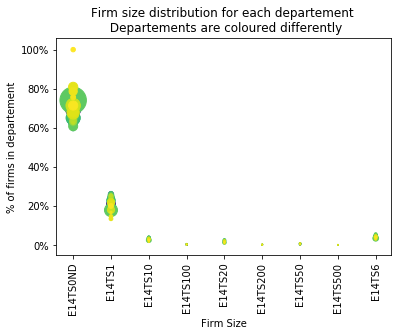

In [119]:
#To do: rather than have the numeric colour index map each to equally spaced values
df_dep_colour_map = df_dep_percentage.DEP.drop_duplicates()
df_dep_colour_map = df_dep_colour_map.reset_index()

fig, ax = plt.subplots()
ax.scatter(x =df_dep_percentage.firm_size_code,
          y = df_dep_percentage.percentage,
          s = 10000 * df_dep_percentage.value / np.sum(df_dep_percentage.value),
          c = df_dep_percentage.merge(df_dep_colour_map)['index'])

x_labels = ax.get_xticklabels()
plt.setp(x_labels, rotation=90)

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

ax.set(xlabel='Firm Size', 
       ylabel='% of firms in departement',
       title='Firm size distribution for each departement \n Departements are distinguished by colour')

plt.show()

In [ ]:
#The main difference is % of firms that are small. We would expect this to be an urban rural divide.
#Let's see if that's the case.

